In [1]:
import os

from sklearn import linear_model
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from rocketlogger.data import RocketLoggerData

import yaml
try:
    from yaml import CLoader as Loader
except ImportErorr:
    from yaml import Loader

In [2]:
def load_data(cfg, datafiles):
    """Loads csv data files and converts measurements to SI units using the defined config
    
    Parameters
    ----------
    cfg : dict
        Board configuration
    datafiles : list
        List of data files paths
        
    Returns
    -------
    pd.DataFrame
        Concatenated dataframe from all datafiles
    """
    
    df_list = []
    for d in datafiles:
        df = pd.read_csv(d)
        df_list.append(df)
    
    data = pd.concat(df_list, ignore_index=True)
    data  = df.set_index("V")
    
    data["I_in"] = data["I_in"] * 1e6
    data["I_meas"] = data["V_i"] / cfg["r_sense"] / cfg["gain"] * 1e6
    data["V_meas"] = data["V_2x"]
    
    return data

In [3]:
def load_rld(path, channel, start, stop, step):
    """Loads rocketlogger data from csv and truncates to the nearest step in the SMU.
    
    Parameters
    ----------
    path : str
        Path to rocketlogger binary data
    start : float
        Starting source value
    stop : float
        Stopping source value
    step : float
        Step source value
        
    Returns
    -------
    pd.DataFrame
        Dataframe of rocketlogger data
    """
    
    # Load RL binary data
    rld = RocketLoggerData(path)
    
    source_range = np.arange(start, stop, step)
    
    def estimate_input(x):
        """Estimate the input voltage based on measure voltage

        Parameters
        ----------
        x : float
            Inputted row

        Returns
        -------
        float
            Closest value to v_range
        """

        diff = np.abs(source_range - x)
        idx = np.argmin(diff)
        return source_range[idx]

    rld_df = pd.DataFrame(rld.get_data(), columns=rld.get_channel_names())
    rld_df["source"] = rld_df[channel].apply(estimate_input)
    rld_df["input"] = rld_df["source"]
    rld_df = rld_df.set_index("source")
    return rld_df

In [4]:
# Config file name
cfg_path = "data/config.yaml"
# Data file name
datafiles = ["data/sps3_temp_2022-10-14T09:10:50-07:00.csv"]
# Evaluation data name
evalfiles = ["data/sps3_temp_2022-10-15T18:37:56-07:00.csv"]

# Read config
with open(cfg_path, "r") as f:
    cfg = yaml.load(f, Loader=Loader)

# SPS data
data = load_data(cfg, datafiles)

v_input_cols = ["V_meas"]
i_input_cols = ["I_meas"]

v_model = linear_model.LinearRegression()
v_model.fit(data[v_input_cols], data["V_in"])

i_model = linear_model.LinearRegression()
i_model.fit(data[i_input_cols], data["I_in"])

eval_data = load_data(cfg, evalfiles)

eval_data["V_fit"] = v_model.predict(eval_data[v_input_cols])
eval_data["I_fit"] = i_model.predict(eval_data[i_input_cols])

# RL data
rld_v = load_rld("data/rl/20220826_200050_eval_v.rld", "V1", 0.1, 1, 0.05)
rld_i = load_rld("data/rl/20220826_200050_eval_i.rld", "I1L", 45e-6, 454e-6, 22.7222e-6)
# adjust units
rld_i.index = rld_i.index * 1e6
rld_i["input"] = rld_i["input"] * 1e6
rld_i["I1L"] = rld_i["I1L"] * 1e6

In [5]:
data

,V_in,I_in,V_i,V_2x,T,I_meas,V_meas
V,,,,,,,
0.10,0.100077,50.67846,0.207479,0.107403,21.420000,83.324900,0.107403
0.10,0.100075,50.67866,0.207583,0.107298,21.629999,83.366667,0.107298
0.10,0.100075,50.67761,0.207535,0.107411,21.629999,83.347390,0.107411
0.10,0.100074,50.67751,0.207640,0.107282,21.639999,83.389558,0.107282
0.10,0.100076,50.67684,0.207551,0.107331,21.639999,83.353815,0.107331
...,...,...,...,...,...,...,...
0.95,0.949981,396.44800,1.902833,0.962736,21.660000,764.189960,0.962736
0.95,0.949981,396.44640,1.902833,0.962785,21.650000,764.189960,0.962785
0.95,0.949980,396.44570,1.902813,0.963002,21.660000,764.181928,0.963002


In [6]:
def plot_accuracy(data):
    """Plots a graph showing the accuracy of measurements y to ideal values x
    
    Parameters
    ----------
    data : list(tuple)
        List of tuples in the format (ideal, meas)
        
    Returns
    -------
    fig, ax
        Matplotlib figure, same format as plt.subplots
    """
    
    fig, ax = plt.subplots()
    
    for (x, y) in data:
        rel = y / x
        rel = rel.groupby(level=0).describe()
        ax.errorbar(x.groupby(level=0).mean(), rel["mean"], yerr=rel["std"])
        
    ax.axhline(y=1, linestyle=':', color='k', linewidth='3')
    ax.grid()
    
    return (fig, ax)

Text(0, 0.5, 'Relative Measurement (V/V)')

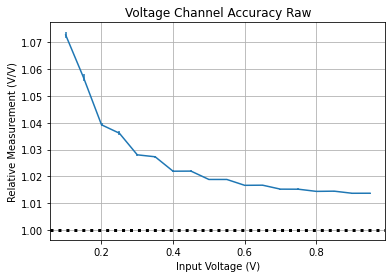

In [7]:
fig, ax = plot_accuracy([
    (data["V_in"], data["V_meas"]),

])

ax.set_title("Voltage Channel Accuracy Raw")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")

Text(0, 0.5, 'Relative Measurement (A/A)')

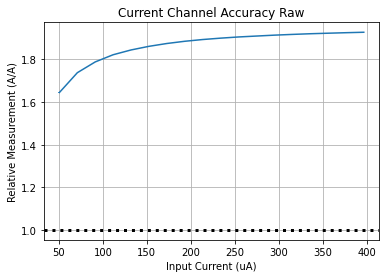

In [8]:
fig, ax = plot_accuracy([
    (data["I_in"], data["I_meas"]),
])

ax.set_title("Current Channel Accuracy Raw")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


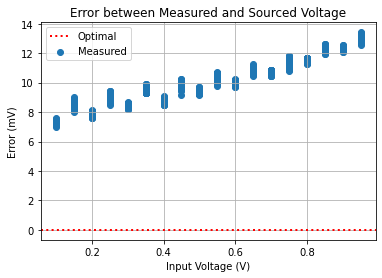

In [9]:
fig, ax = plt.subplots()
ax.axhline(y=0, linestyle=':', color='r', linewidth='2')
ax.scatter(data["V_in"], (data["V_meas"] - data["V_in"]) * 1e3)
ax.set_title("Error between Measured and Sourced Voltage")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Error (mV)")
ax.legend(["Optimal", "Measured"])
ax.grid(True)
fig.savefig("nonlin_v.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


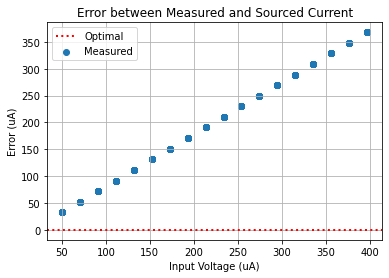

In [10]:
fig, ax = plt.subplots()
ax.axhline(y=0, linestyle=':', color='r', linewidth='2')
ax.scatter(data["I_in"], data["I_meas"] - data["I_in"])
ax.set_title("Error between Measured and Sourced Current")
ax.set_xlabel("Input Voltage (uA)")
ax.set_ylabel("Error (uA)")
ax.legend(["Optimal", "Measured"])
ax.grid(True)
fig.savefig("nonline_i.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


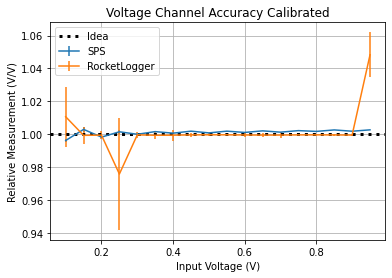

In [11]:
fig, ax = plot_accuracy([
    (eval_data["V_in"], eval_data["V_fit"]),
    (rld_v["input"], rld_v["V1"]),
])

ax.set_title("Voltage Channel Accuracy Calibrated")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")
ax.legend(["Idea", "SPS", "RocketLogger"])
fig.savefig("acc_v.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


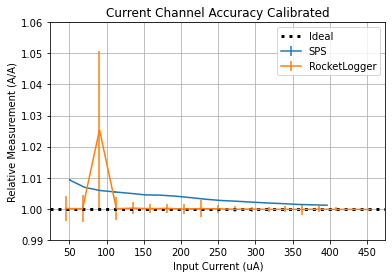

In [12]:
fig, ax = plot_accuracy([
    (eval_data["I_in"], eval_data["I_fit"]),
    (rld_i["input"], rld_i["I1L"]),
])

ax.set_title("Current Channel Accuracy Calibrated")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")
ax.set_ylim(0.99, 1.06)
ax.legend(["Ideal", "SPS", "RocketLogger"])
fig.savefig("acc_i.eps")

## SPS Voltage Accuracy

In [13]:
mae_v = abs(eval_data["V_in"] - eval_data["V_fit"]) / eval_data["V_in"]
mae_v.describe()

count    1800.000000
mean        0.001805
std         0.000978
min         0.000006
25%         0.001133
50%         0.001790
75%         0.002328
max         0.006106
dtype: float64

## SPS Current Accuracy

In [14]:
mae_i = abs(eval_data["I_in"] - eval_data["I_fit"]) / eval_data["I_in"]
mae_i.describe()

count    1800.000000
mean        0.003690
std         0.002143
min         0.001067
25%         0.001870
50%         0.003286
75%         0.004946
max         0.010084
dtype: float64

## Rocketlogger Voltage Accuracy

In [15]:
rl_mae_v = abs(rld_i["input"] - rld_i["I1L"]) / rld_i["input"]
rl_mae_v.describe()

count    2.100000e+04
mean     2.585558e-03
std      8.061865e-03
min      1.578984e-16
25%      2.965882e-04
50%      6.321702e-04
75%      1.743333e-03
max      8.313684e-02
dtype: float64

## Rocketlogger Current Accuracy

In [16]:
rl_mae_i = abs(rld_v["input"] - rld_v["V1"]) / rld_v["input"]
rl_mae_i.describe()

count    2.300000e+04
mean     2.187147e-02
std      2.383356e-02
min      2.220446e-16
25%      7.142600e-04
50%      7.993900e-03
75%      5.183595e-02
max      2.165464e-01
dtype: float64